#### Setup

In [27]:
from __future__ import absolute_import, division, print_function, unicode_literals
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import os
import sys
from datetime import datetime
from pathlib import Path

In [20]:
import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator
tf.__version__

'1.13.1'

In [21]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 11630318986148473258
]


In [8]:
img_folder = '../data/output_images/'

train_folder = '../data/output_images/train/'
test_folder = '../data/output_images/test/'
validation_folder = '../data/output_images/validation/'

sample_size = .1

img_size = (320,320)

In [35]:
root = os.path.abspath(train_folder)
root

'/Users/jessedecker/projects/rail_classification/data/output_images/train'

### Loading images into tf

In [13]:
def preprocess_image(image):
    img_tensor = tf.image.decode_image(image)
    
#     image = tf.image.decode_jpeg(image, channels=3)
    img_final = tf.image.resize_images(
        img_tensor,
        [192, 192],
        align_corners=False,
        preserve_aspect_ratio=False,
    )
    image /= 255.0  # normalize to [0,1] range

    return image

In [6]:
def load_and_preprocess_image(path):
    image = tf.read_file(path)
    return preprocess_image(image)

In [36]:
img_path = root+'/1/0.png'
print(img_path)

/Users/jessedecker/projects/rail_classification/data/output_images/train/1/0.png


In [37]:
load_and_preprocess_image(img_path)

ValueError: 'images' contains no shape.

In [38]:
img_raw = tf.io.read_file(img_path)
print(repr(img_raw)[:100]+"...")

<tf.Tensor 'ReadFile_5:0' shape=() dtype=string>...


In [39]:
img_tensor = tf.image.decode_image(img_raw)

print(img_tensor.shape)
print(img_tensor.dtype)

<unknown>
<dtype: 'uint8'>


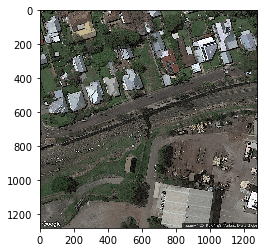

In [18]:
img = Image.open(img_path)

plt.imshow(img)

In [ ]:
img_path = all_image_paths[0]
label = all_image_labels[0]

plt.imshow(load_and_preprocess_image(img_path))
plt.grid(False)
plt.xlabel(caption_image(img_path).encode('utf-8'))
plt.title(label_names[label].title())
print()

In [ ]:
img_final = tf.image.resize_images(
    img_tensor,
    [192, 192],
    align_corners=False,
    preserve_aspect_ratio=False,
)

In [ ]:
labels = np.asarray(df.Catenary.tolist())
features = np.asarray(df.Image.tolist())

In [ ]:
features = features.reshape(len(features),-1)

In [ ]:
features.shape

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(features,labels,test_size = 0.20, random_state=42)

X_train, X_test = X_train / 255.0, X_test / 255.0

In [ ]:
len(X_test)

In [ ]:
with tf.device('/gpu:0'):
    model = tf.keras.models.Sequential([
        tf.keras.layers.Dense(32, activation=tf.nn.relu),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Flatten(input_shape=(28,28)),
        tf.keras.layers.Dense(10, activation=tf.nn.sigmoid)
    ])

    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    model.fit(X_train, y_train, epochs=5)

    model.evaluate(X_test, y_test)

In [ ]:
train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        '../data/output_images/train/',
        target_size=(66, 66),
        batch_size=32,
        class_mode='binary')

# validation_generator = test_datagen.flow_from_directory(
#         '../data/output_images/test',
#         target_size=(20, 20),
#         batch_size=32,
#         class_mode='binary')


# model = tf.keras.models.Sequential([
#         tf.keras.layers.Dense(32, activation=tf.nn.relu),
#         tf.keras.layers.Dropout(0.2),
#         tf.keras.layers.Flatten(input_shape=(28,28)),
#         tf.keras.layers.Dense(10, activation=tf.nn.sigmoid)
#     ])

# model.compile(optimizer='adam',
#               loss='sparse_categorical_crossentropy',
#               metrics=['accuracy'])

# model.fit_generator(
#         train_generator,
#         steps_per_epoch=2000,
#         epochs=50,
#         validation_data=validation_generator,
#         validation_steps=800)

In [ ]:
with tf.device('/gpu:0'):
    
    X_train, X_test, y_train, y_test = train_test_split(features,labels,test_size = 0.20, random_state=42)

    X_train, X_test = X_train / 255.0, X_test / 255.0
    
    model = tf.keras.models.Sequential([
        tf.keras.layers.Dense(32, activation=tf.nn.relu),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Flatten(input_shape=(28,28)),
        tf.keras.layers.Dense(10, activation=tf.nn.sigmoid)
    ])

    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    model.fit(X_train, y_train, epochs=5)

    model.evaluate(X_test, y_test)

### Basic Example

In [ ]:
mnist = tf.keras.datasets.mnist

In [ ]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [ ]:
x_train, x_test = x_train / 255.0, x_test / 255.0

In [ ]:
x_train.shape

In [ ]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(28, 28)),
  tf.keras.layers.Dense(512, activation=tf.nn.relu),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(10, activation=tf.nn.softmax)
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
model.fit(x_train, y_train, epochs=5)

model.evaluate(x_test, y_test)